In [67]:
import numpy as np
import scipy as sp
import scipy.stats
import matplotlib.pyplot as plt
from collections import namedtuple

# Завдання 2
Змоделювати ланцюг Маркова з даним інваріантним розподілом 

In [33]:
# Weighted random choice
def ChooseW(distr, values=None, rng=None):
    if rng is None: rng = np.random.default_rng(42)

    cumdistr = distr.cumsum()
    w = rng.random() * cumdistr[-1]

    idx = -1
    for i,cum_p in enumerate(cumdistr):
        if w <= cum_p: 
            idx = i
            break
    if values:
        return values[idx]
    return idx


ZipfMarkovParams = namedtuple('ZipfMarkovParams', 'M, a')
ZipfMarkovResult = namedtuple('ZipfMarkovResult', 'nvisits, nsteps, history')
def MarkovZipf(params: ZipfMarkovParams, stat_offset=2000, n_steps=2000, seed=42, debug=False):
    rng = np.random.default_rng(seed)
    M, a = params
    
    # initial stochastic matrix Q
    #   (sym 1D random walk)
    Q = np.diag(np.ones(M-1), -1) + np.diag(np.ones(M-1), +1)
    Q[0,0] = 1
    Q[-1,-1] = 1
    Q = Q / 2
    if debug:
        print("Init Q:")
        print(Q)

    # alpha_ij
    E = np.arange(1, M+1) # { 1, 2, ..., M }
    Ea = np.float_power(E, a)   # { i^a | i \in E }
    a = np.minimum((Ea.reshape(-1,1) / Ea), 1)
    if debug:
        print("alpha_ij:")
        print(a)

    # modelling
    state = int(M/2) # hardcoded initial state
    n_visits = np.zeros(M)
    history = [state]


    for step in range(n_steps+stat_offset):
        j = ChooseW(Q[state], rng=rng)
        if state != j:
            w = rng.random()
            if w <= a[state,j]:
                state = j
        history.append(state)
        if step > stat_offset:
            n_visits[state] = n_visits[state] + 1
        
    return ZipfMarkovResult(n_visits, n_steps, history)


функція для зручного тестування

In [46]:
def test_zipf(a, M, debug=False, steps=2000):
    zipf_param = ZipfMarkovParams(M, a)
    zipf_res = MarkovZipf(zipf_param, stat_offset=steps, n_steps=steps, debug=debug)
    zipf_true_distr = sp.stats.zipf(zipf_param.a).pmf
    zipf_calc_distr = zipf_res[0] / zipf_res[1]

    E = np.arange(1, M+1)
    plt.title(f"Zipf(a={a}, M={M}, m={steps}, n={steps})")
    plt.plot(E, zipf_true_distr(E), '-o', label='true', lw=1)
    plt.plot(E, zipf_calc_distr, '-o', label='calc', lw=1)
    plt.legend()

### A debug run

Init Q:
[[0.5 0.5 0.  0.  0. ]
 [0.5 0.  0.5 0.  0. ]
 [0.  0.5 0.  0.5 0. ]
 [0.  0.  0.5 0.  0.5]
 [0.  0.  0.  0.5 0.5]]
alpha_ij:
[[1.         0.25       0.11111111 0.0625     0.04      ]
 [1.         1.         0.44444444 0.25       0.16      ]
 [1.         1.         1.         0.5625     0.36      ]
 [1.         1.         1.         1.         0.64      ]
 [1.         1.         1.         1.         1.        ]]


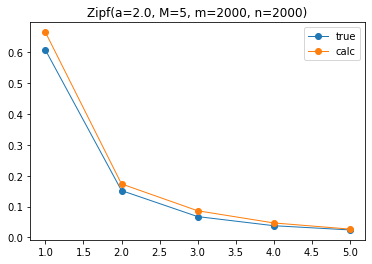

In [57]:
test_zipf(2.0, 5, debug=True)

Бачимо, що матриці сформовані правильно, а розподіл близький до дійсного

### Обчислення із різними параметрами

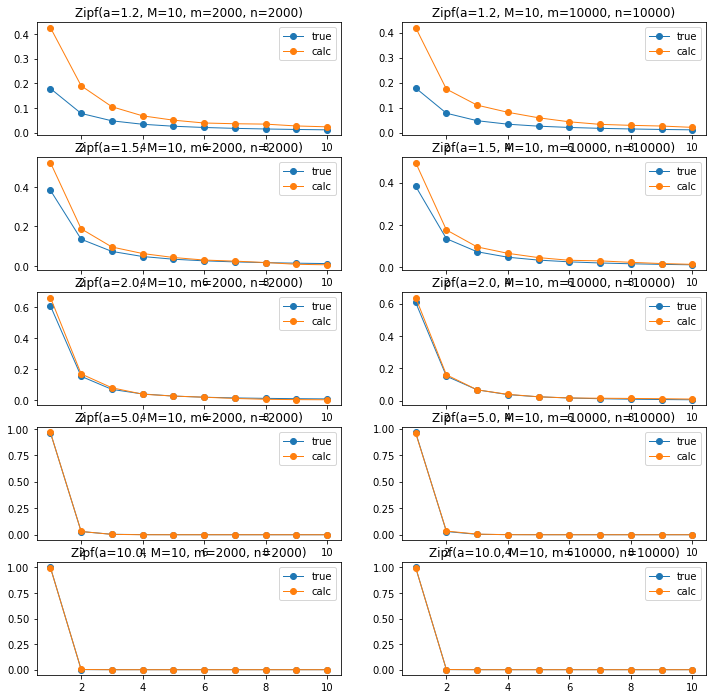

In [61]:
As = [1.2, 1.5, 2.0, 5.0, 10.0]
Steps = [2000, 10_000]

plt.gcf().set_size_inches((12,12))

n = 1
for a in As:
    for s in Steps:
        plt.subplot(len(As),len(Steps),n)
        test_zipf(a,10, steps=s)
        n+=1


Вийшло добре. Помилка для малих $a$ виникає тому, що ланцюг Маркова обчислює ймовірності лише перших станів, а в дійсному розподілі більші значення матимуть суттєву ймовірність. 

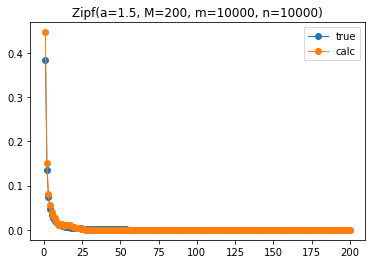

In [66]:
test_zipf(1.5, 200, steps=10000)

За більшого $M$ маємо більшу точність для $a < 1$